### **HÜCRE 1**

In [ ]:
# Kurulum: temel kütüphaneler
!pip -q install pandas numpy regex scikit-learn matplotlib joblib
!pip -q install transformers datasets accelerate evaluate


### **HÜCRE 2**

In [ ]:
import os, json, random, math, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import (
    precision_recall_curve, average_precision_score, classification_report, f1_score
)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.pipeline import Pipeline
import joblib

import torch

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Türkçe normalize yardımcıları
import regex as regx
JOINERS = r"[._\-\|\u2013\u2014]{1,3}"
joiners_between_letters = regx.compile(rf"(?<=\p{{L}}){JOINERS}(?=\p{{L}})", flags=regx.UNICODE)
repeat_3plus = regx.compile(r"(.)\1{2,}", flags=regx.UNICODE)
leet_tbl = str.maketrans({"0":"o","1":"i","!":"i","3":"e","4":"a","@":"a","5":"s","$":"s",
                          "ğ":"g","ü":"u","ş":"s","ı":"i","ç":"c","ö":"o",
                          "Ğ":"G","Ü":"U","Ş":"S","İ":"I","Ç":"C","Ö":"O"})

def normalize_tr(s: str) -> str:
    s = str(s).strip().translate(leet_tbl)
    s = joiners_between_letters.sub("", s)     # s.a_l-a|k -> salak
    s = repeat_3plus.sub(r"\1\1", s)           # saaalllaakk -> saallaakk
    return s

os.makedirs("artifacts", exist_ok=True)


### **HÜCRE 3**

In [ ]:
# 🧩 Hücre 3 — Veriyi URL’den yüklüyor
import pandas as pd

URL = "https://coltekin.github.io/offensive-turkish/troff-v1.0.tsv.gz"
df_raw = pd.read_csv(
    URL,
    sep="\t",
    compression="gzip",
    dtype=str,
    engine="python"
)

df_raw.columns = [c.lower() for c in df_raw.columns]
print(df_raw.shape)
df_raw.head(2)


(35284, 4)


,id,timestamp,text,label
0,973568937593065472,1520952977415,@USER06095 Hırsız demişken Tuncay sizin şu 1.2...,grp
1,973568937723035648,1520952977446,Ne bileyim sen hastayım deyince bende veterine...,ind


### **HÜCRE 4**

In [ ]:
# 🧩 Hücre 4 — Etiket eşleme (çoklu etiket + X), hijyen, 60/20/20 bölme. Validation için veri setini böldük.
import numpy as np, re, regex as regx
from sklearn.model_selection import train_test_split

df = df_raw.copy()

# Etiketi parçala (harf dışı ayırıcılarla split), küçük harfe indir.
def parse_labels(s: str):
    s = str(s).lower()
    labs = re.findall(r"[a-z]+", s)  # harf serilerini çek
    return set(labs)

labels_parsed = df["label"].apply(parse_labels)

# 1) Sadece X olanları at
mask_x_only = labels_parsed.apply(lambda s: s == {"x"})
df = df[~mask_x_only].reset_index(drop=True)
labels_parsed = labels_parsed.loc[df.index]

# 2) İkili etiket (y): non=0, diğer her şey=1
def to_binary(s):
    if s == {"non"}:
        return 0
    # prof/grp/ind/oth ya da bunların kombinasyonları → 1
    if any(t in s for t in {"prof", "grp", "ind", "oth"}):
        return 1
    # buraya nadiren düşer (örn. boş string vs.); güvenli taraf: 0
    return 0

df["y"] = labels_parsed.apply(to_binary)

# 3) Belirsiz bayrağı: X başka etiketle birlikteyse
df["uncertain"] = labels_parsed.apply(lambda s: "x" in s and len(s) > 1)

# --- Türkçe normalize + temizlik + dedup (normalize metne göre) ---
JOINERS = r"[._\-\|\u2013\u2014]{1,3}"
joiners_between_letters = regx.compile(rf"(?<=\p{{L}}){JOINERS}(?=\p{{L}})", flags=regx.UNICODE)
repeat_3plus = regx.compile(r"(.)\1{2,}", flags=regx.UNICODE)
leet_tbl = str.maketrans({"0":"o","1":"i","!":"i","3":"e","4":"a","@":"a","5":"s","$":"s",
                          "ğ":"g","ü":"u","ş":"s","ı":"i","ç":"c","ö":"o",
                          "Ğ":"G","Ü":"U","Ş":"S","İ":"I","Ç":"C","Ö":"O"})

def normalize_tr(s: str) -> str:
    s = str(s).strip().translate(leet_tbl)
    s = joiners_between_letters.sub("", s)     # s.a_l-a|k -> salak
    s = repeat_3plus.sub(r"\1\1", s)           # saaalllaakk -> saallaakk
    return s

df["text_norm"] = df["text"].apply(normalize_tr).str.lower()
df = df[df["text_norm"].str.len() >= 3]
df = df.drop_duplicates(subset=["text_norm"]).reset_index(drop=True)

# (Opsiyonel) belirsizleri eğitimden dışla:
# df_train_pool = df[~df["uncertain"]].copy()
# sonra bölmeyi df_train_pool üzerinden yaparsın. Şimdilik hepsini kullanıyoruz.

# 60/20/20 bölme (stratified)
dtrain, dtemp = train_test_split(df, test_size=0.4, random_state=42, stratify=df["y"])
dvalid, dtest = train_test_split(dtemp, test_size=0.5, random_state=42, stratify=dtemp["y"])

print(f"train={len(dtrain)}, valid={len(dvalid)}, test={len(dtest)} | pos_rate(train)={dtrain['y'].mean():.3f} | uncertain(train)={dtrain['uncertain'].mean():.3f}")


train=21169, valid=7056, test=7057 | pos_rate(train)=0.194 | uncertain(train)=0.000


### **HÜCRE 4**

In [ ]:
# 🧩 Hücre 4 — Etiket eşleme (çoklu etiket + X), hijyen, 60/20/20 bölme
import numpy as np, re, regex as regx
from sklearn.model_selection import train_test_split

df = df_raw.copy()

# Etiketi parçala (harf dışı ayırıcılarla split), küçük harfe indir.
def parse_labels(s: str):
    s = str(s).lower()
    labs = re.findall(r"[a-z]+", s)  # harf serilerini çek
    return set(labs)

labels_parsed = df["label"].apply(parse_labels)

# 1) Sadece X olanları at
mask_x_only = labels_parsed.apply(lambda s: s == {"x"})
df = df[~mask_x_only].reset_index(drop=True)
labels_parsed = labels_parsed.loc[df.index]

# 2) İkili etiket (y): non=0, diğer her şey=1
def to_binary(s):
    if s == {"non"}:
        return 0
    # prof/grp/ind/oth ya da bunların kombinasyonları → 1
    if any(t in s for t in {"prof", "grp", "ind", "oth"}):
        return 1
    # buraya nadiren düşer (örn. boş string vs.); güvenli taraf: 0
    return 0

df["y"] = labels_parsed.apply(to_binary)

# 3) Belirsiz bayrağı: X başka etiketle birlikteyse
df["uncertain"] = labels_parsed.apply(lambda s: "x" in s and len(s) > 1)

# --- Türkçe normalize + temizlik + dedup (normalize metne göre) ---
JOINERS = r"[._\-\|\u2013\u2014]{1,3}"
joiners_between_letters = regx.compile(rf"(?<=\p{{L}}){JOINERS}(?=\p{{L}})", flags=regx.UNICODE)
repeat_3plus = regx.compile(r"(.)\1{2,}", flags=regx.UNICODE)
leet_tbl = str.maketrans({"0":"o","1":"i","!":"i","3":"e","4":"a","@":"a","5":"s","$":"s",
                          "ğ":"g","ü":"u","ş":"s","ı":"i","ç":"c","ö":"o",
                          "Ğ":"G","Ü":"U","Ş":"S","İ":"I","Ç":"C","Ö":"O"})

def normalize_tr(s: str) -> str:
    s = str(s).strip().translate(leet_tbl)
    s = joiners_between_letters.sub("", s)     # s.a_l-a|k -> salak
    s = repeat_3plus.sub(r"\1\1", s)           # saaalllaakk -> saallaakk
    return s

df["text_norm"] = df["text"].apply(normalize_tr).str.lower()
df = df[df["text_norm"].str.len() >= 3]
df = df.drop_duplicates(subset=["text_norm"]).reset_index(drop=True)

# df_train_pool = df[~df["uncertain"]].copy()
# sonra bölmeyi df_train_pool üzerinden yaparsın. Şimdilik hepsini kullanıyoruz.

# 60/20/20 bölme
dtrain, dtemp = train_test_split(df, test_size=0.4, random_state=42, stratify=df["y"])
dvalid, dtest = train_test_split(dtemp, test_size=0.5, random_state=42, stratify=dtemp["y"])

print(f"train={len(dtrain)}, valid={len(dvalid)}, test={len(dtest)} | pos_rate(train)={dtrain['y'].mean():.3f} | uncertain(train)={dtrain['uncertain'].mean():.3f}")


train=21169, valid=7056, test=7057 | pos_rate(train)=0.194 | uncertain(train)=0.000


### **HÜCRE 5**

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[Baseline] AP(valid)=0.617 | thr=0.290
              precision    recall  f1-score   support

           0      0.906     0.879     0.892      5688
           1      0.552     0.621     0.585      1369

    accuracy                          0.829      7057
   macro avg      0.729     0.750     0.738      7057
weighted avg      0.837     0.829     0.833      7057



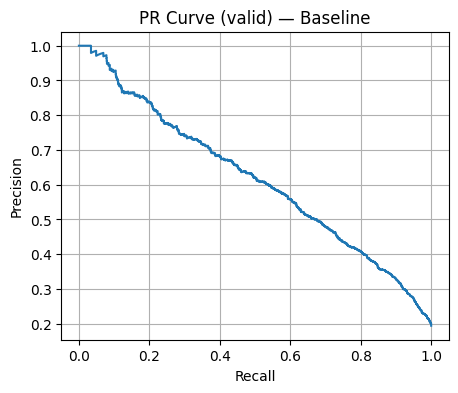

In [ ]:
# 🧩 Hücre 5 — Güçlü Char TF-IDF + LR (kalibre) grid-search, eşiği valid’te seç, testte raporla
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import precision_recall_curve, average_precision_score, classification_report
import numpy as np, joblib, json, matplotlib.pyplot as plt

pipe = Pipeline([
    ("vec", TfidfVectorizer(analyzer="char", ngram_range=(3,5), min_df=3)),
    ("clf", CalibratedClassifierCV(LogisticRegression(max_iter=400, class_weight="balanced"), cv=3))
])

param_grid = {
    "vec__ngram_range": [ (3,5), (3,6) ],
    "vec__min_df": [2,3,5],
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(pipe, param_grid, scoring="average_precision", cv=cv, n_jobs=-1, verbose=1)
grid.fit(dtrain["text_norm"], dtrain["y"])

proba_va = grid.predict_proba(dvalid["text_norm"])[:,1]
ap_va = average_precision_score(dvalid["y"], proba_va)

prec_bl, rec_bl, thr_bl_arr = precision_recall_curve(dvalid["y"], proba_va)
f1_bl = 2*(prec_bl*rec_bl)/(prec_bl+rec_bl+1e-9)
best_idx = int(np.nanargmax(f1_bl))
thr_bl = float(thr_bl_arr[best_idx]) if best_idx < len(thr_bl_arr) else 0.5

# Test raporu
proba_te = grid.predict_proba(dtest["text_norm"])[:,1]
yhat_te = (proba_te >= thr_bl).astype(int)

print(f"[Baseline] AP(valid)={ap_va:.3f} | thr={thr_bl:.3f}")
print(classification_report(dtest["y"], yhat_te, digits=3))

# Kaydet
joblib.dump(grid.best_estimator_, "artifacts/charLR.joblib")
with open("artifacts/charLR_threshold.json","w",encoding="utf-8") as f:
    json.dump({"threshold": thr_bl, "ap_valid": float(ap_va)}, f, ensure_ascii=False, indent=2)

# PR eğrisi (valid)
plt.figure(figsize=(5,4))
plt.plot(rec_bl, prec_bl)
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("PR Curve (valid) — Baseline")
plt.grid(True); plt.show()


### **HÜCRE 6**

In [ ]:
# 🧩 Hücre 6 — Hata analizi (FP/FN listeleri, valid set)
from IPython.display import display

va = dvalid.copy()
va["proba"] = proba_va
va["pred"]  = (proba_va >= thr_bl).astype(int)

fp = va[(va["pred"]==1) & (va["y"]==0)].sort_values("proba", ascending=False).head(25)
fn = va[(va["pred"]==0) & (va["y"]==1)].sort_values("proba", ascending=True).head(25)

print("FALSE POSITIVES (valid) — top 10:")
display(fp[["text","proba"]].head(10))
print("FALSE NEGATIVES (valid) — top 10:")
display(fn[["text","proba"]].head(10))

fp[["text","proba"]].to_csv("artifacts/fp_valid.csv", index=False)
fn[["text","proba"]].to_csv("artifacts/fn_valid.csv", index=False)


FALSE POSITIVES (valid) — top 10:


,text,proba
16750,Yapılan yanlışları adaletsizliği görürsen #sus...,0.941645
15311,@USER05942 Metin Akpınar faşistlikten ve faşis...,0.916014
18565,Demet Akalın kendini niye meze yapıyorsun Reyn...,0.889716
23564,@USER08353 @USER09838 Onları kullanarak kürt s...,0.877937
25737,@USER01698 @USER03891 Fetöye en başta karşı çı...,0.876662
3084,#TFF yetkilerine bakın en yakın zaman da kendi...,0.873100
26200,"Nerde salak, nerde gerizekalı varsa elimle koy...",0.867672
34981,@USER16696 @USER15086 @USER17952 boş boş konuş...,0.864046
2968,@USER07960 nasıl yöneteceğini bilmiyoruz diyor...,0.863974
33519,Kızlar salak salak şeylere Allahım nasip et di...,0.861177


FALSE NEGATIVES (valid) — top 10:


,text,proba
28381,Böyle olmasındansa ölmen daha iyi,0.012821
26578,@USER09066 Bu hayatta çok da gerekli bir insan...,0.014098
5907,SADECE 2 SAAT UYUDUM SADECE ABVVVVVVC,0.014662
22346,@USER09899 @USER00020 Ben çok isterim muhteşem...,0.017877
31249,Gençliğimin baharında sevdiğim kadınla gezmek ...,0.018290
28273,@USER12799 @USER17072 Taehyung gay çift var mı,0.018869
27219,anlık seni istemiyorum isimli wp kitabı okuyor...,0.018981
17145,@USER07683 Hocam verirse Ekime vermezlerse sik...,0.021800
16441,Özenilen olmak güzel bir şey diyordum tamam da...,0.023637
31493,"Böyleleri yakar gemileri, sonra yüzerek geri g...",0.024098


### **HÜCRE 7**

In [ ]:
# 🧩 Hücre 7 — Türkçe BERT fine-tune
import os, inspect, numpy as np, torch, json
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
try:
    from transformers import EarlyStoppingCallback
    HAS_EARLY_STOP_CB = True
except Exception:
    HAS_EARLY_STOP_CB = False

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import precision_recall_curve, average_precision_score, classification_report

os.environ["WANDB_DISABLED"] = "true"
os.environ["HF_HUB_DISABLE_TELEMETRY"] = "1"

MODEL_NAME   = "dbmdz/bert-base-turkish-cased"
MAX_LEN      = 160
BATCH_TRAIN  = 32
BATCH_EVAL   = 64
EPOCHS       = 3
LR           = 2e-5
SEED         = 42
np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)

tok = AutoTokenizer.from_pretrained(MODEL_NAME)

def enc(batch):
    return tok(batch["text"], truncation=True, padding="max_length", max_length=MAX_LEN)

# Pandas → Dataset
ds_tr = Dataset.from_pandas(dtrain[["text","y"]].rename(columns={"y":"labels"}), preserve_index=False)
ds_va = Dataset.from_pandas(dvalid[["text","y"]].rename(columns={"y":"labels"}), preserve_index=False)

# Tokenize
ds_tr = ds_tr.map(enc, batched=True, remove_columns=["text"])
ds_va = ds_va.map(enc, batched=True, remove_columns=["text"])
ds_tr.set_format(type="torch", columns=["input_ids","attention_mask","labels"])
ds_va.set_format(type="torch", columns=["input_ids","attention_mask","labels"])

# Model
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

# Class weights (numpy array)
classes  = np.array([0,1], dtype=np.int64)
y_train  = dtrain["y"].to_numpy()
cls_w_np = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
cls_w    = torch.tensor(cls_w_np, dtype=torch.float)

# Metrikler (PR-AUC + F1_max)
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = torch.softmax(torch.tensor(logits), dim=1).numpy()[:,1]
    ap    = average_precision_score(labels, probs)
    prec, rec, thr = precision_recall_curve(labels, probs)
    f1    = 2*(prec*rec)/(prec+rec+1e-9)
    return {"pr_auc": float(ap), "f1_max": float(np.nanmax(f1))}

# TrainingArguments
ta_supported = set(inspect.signature(TrainingArguments).parameters.keys())
has_eval    = "evaluation_strategy" in ta_supported
has_save    = "save_strategy" in ta_supported
has_best    = "load_best_model_at_end" in ta_supported
has_metric  = "metric_for_best_model" in ta_supported
has_report  = "report_to" in ta_supported
has_gib     = "greater_is_better" in ta_supported

ta = {
    "output_dir": "artifacts/berturk",
    "learning_rate": LR,
    "per_device_train_batch_size": BATCH_TRAIN,
    "per_device_eval_batch_size": BATCH_EVAL,
    "num_train_epochs": EPOCHS,
    "weight_decay": 0.01,
    "logging_steps": 50,
    "seed": SEED,
}
if has_report:
    ta["report_to"] = "none"

# Eval/save/best
USE_EARLY_STOP = False
if has_eval and has_save:
    ta["evaluation_strategy"] = "epoch"
    ta["save_strategy"] = "epoch"
    if has_best and has_metric and has_gib:
        ta["load_best_model_at_end"] = True
        ta["metric_for_best_model"] = "pr_auc"
        ta["greater_is_better"] = True
        USE_EARLY_STOP = HAS_EARLY_STOP_CB
else:
    USE_EARLY_STOP = False  # eski sürüm: best/early stop devre dışı

ta_filtered = {k:v for k,v in ta.items() if k in ta_supported}
args = TrainingArguments(**ta_filtered)

# 🔧 Ağırlıklı loss
def custom_loss(model, inputs, return_outputs=False, **kwargs):
    labels  = inputs.get("labels")
    outputs = model(**inputs)
    logits  = outputs.logits
    loss_f  = torch.nn.CrossEntropyLoss(weight=cls_w.to(logits.device))
    loss    = loss_f(logits.view(-1, 2), labels.view(-1))
    if return_outputs:
        return (loss, outputs)
    return loss

# Trainer
trainer_kwargs = dict(
    model=model,
    args=args,
    train_dataset=ds_tr,
    eval_dataset=ds_va,
    compute_metrics=compute_metrics,
)
if USE_EARLY_STOP:
    trainer_kwargs["callbacks"] = [EarlyStoppingCallback(early_stopping_patience=1, early_stopping_threshold=0.0)]

trainer = Trainer(**trainer_kwargs)
trainer.compute_loss = custom_loss

# 🏋️ Eğitim
trainer.train()

# ✅ Valid üzerinde en iyi F1 eşiği
pred_va  = trainer.predict(ds_va)
probs_va = torch.softmax(torch.tensor(pred_va.predictions), dim=1).numpy()[:,1]
prec_b, rec_b, thr_b = precision_recall_curve(dvalid["y"].values, probs_va)
f1_b    = 2*(prec_b*rec_b)/(prec_b+rec_b+1e-9)
best_i  = int(np.nanargmax(f1_b))
thr_bert = float(thr_b[best_i]) if best_i < len(thr_b) else 0.5
print("BERT best threshold (valid):", round(thr_bert, 3))

# 🧪 Test raporu (seçilen eşikle)
enc_te  = tok(dtest["text"].tolist(), truncation=True, padding="max_length", max_length=MAX_LEN, return_tensors="pt")
model.eval()
with torch.no_grad():
    logits_te = model(**{k: v.to(model.device) for k,v in enc_te.items()}).logits
probs_te = torch.softmax(logits_te, dim=1)[:,1].cpu().numpy()
yhat_te  = (probs_te >= thr_bert).astype(int)
print(classification_report(dtest["y"], yhat_te, digits=3))

# 💾 Kaydet (model + tokenizer + threshold)
trainer.save_model("artifacts/berturk/model")
tok.save_pretrained("artifacts/berturk/tokenizer")
with open("artifacts/berturk/threshold.json","w",encoding="utf-8") as f:
    json.dump({"threshold": float(thr_bert)}, f, ensure_ascii=False, indent=2)


Map:   0%|          | 0/21169 [00:00<?, ? examples/s]

Map:   0%|          | 0/7056 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
50,0.680100
100,0.566300
150,0.489900
200,0.454400
250,0.429700
300,0.452200
350,0.375600
400,0.430000
450,0.412500
500,0.405100


BERT best threshold (valid): 0.341


OutOfMemoryError: CUDA out of memory. Tried to allocate 12.92 GiB. GPU 0 has a total capacity of 39.56 GiB of which 12.62 GiB is free. Process 17166 has 26.93 GiB memory in use. Of the allocated memory 21.34 GiB is allocated by PyTorch, and 5.08 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

### **HÜCRE 7.1**

In [ ]:
# 🧩 Hücre 7.1 — Test raporu
import os, numpy as np, torch
from sklearn.metrics import classification_report

# CUDA bellek parçalanmasını azaltıyor
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
if torch.cuda.is_available():
    torch.cuda.empty_cache()

def predict_probs_batched(model, texts, tokenizer, max_len=160, bs=64, use_amp=True):
    """
    texts: list[str]
    bs   : batch size (gerekirse 64 → 32 → 16 düşür)
    use_amp: GPU varsa otomatik mixed precision
    """
    model.eval()
    probs_all = []
    for i in range(0, len(texts), bs):
        chunk = texts[i:i+bs]
        enc = tokenizer(
            chunk, truncation=True, padding="max_length", max_length=max_len, return_tensors="pt"
        )
        enc = {k: v.to(model.device) for k, v in enc.items()}
        with torch.no_grad():
            if use_amp and torch.cuda.is_available():
                with torch.cuda.amp.autocast():
                    logits = model(**enc).logits
            else:
                logits = model(**enc).logits
        probs = torch.softmax(logits, dim=1)[:, 1].detach().cpu().numpy()
        probs_all.append(probs)
        # bellek temizliği
        del enc, logits
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    return np.concatenate(probs_all, axis=0)

# dtest üzerinde batch'li inference
texts_test = dtest["text"].tolist()
probs_te = predict_probs_batched(model, texts_test, tok, max_len=MAX_LEN, bs=64, use_amp=True)

yhat_te = (probs_te >= thr_bert).astype(int)
print(classification_report(dtest["y"], yhat_te, digits=3))


/tmp/ipython-input-395782621.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


              precision    recall  f1-score   support

           0      0.938     0.902     0.920      5688
           1      0.649     0.754     0.697      1369

    accuracy                          0.873      7057
   macro avg      0.793     0.828     0.808      7057
weighted avg      0.882     0.873     0.877      7057



In [ ]:
import os, json, glob, textwrap, pprint
print("Kaydedilenler:")
for p in sorted(glob.glob("artifacts/berturk/**", recursive=True)):
    print(" -", p)

print("\nEşik dosyası:")
with open("artifacts/berturk/threshold.json","r",encoding="utf-8") as f:
    print(pprint.pformat(json.load(f)))


Kaydedilenler:
 - artifacts/berturk/
 - artifacts/berturk/checkpoint-1000
 - artifacts/berturk/checkpoint-1000/config.json
 - artifacts/berturk/checkpoint-1000/model.safetensors
 - artifacts/berturk/checkpoint-1000/optimizer.pt
 - artifacts/berturk/checkpoint-1000/rng_state.pth
 - artifacts/berturk/checkpoint-1000/scheduler.pt
 - artifacts/berturk/checkpoint-1000/trainer_state.json
 - artifacts/berturk/checkpoint-1000/training_args.bin
 - artifacts/berturk/checkpoint-1500
 - artifacts/berturk/checkpoint-1500/config.json
 - artifacts/berturk/checkpoint-1500/model.safetensors
 - artifacts/berturk/checkpoint-1500/optimizer.pt
 - artifacts/berturk/checkpoint-1500/rng_state.pth
 - artifacts/berturk/checkpoint-1500/scheduler.pt
 - artifacts/berturk/checkpoint-1500/trainer_state.json
 - artifacts/berturk/checkpoint-1500/training_args.bin
 - artifacts/berturk/checkpoint-1986
 - artifacts/berturk/checkpoint-1986/config.json
 - artifacts/berturk/checkpoint-1986/model.safetensors
 - artifacts/ber

### **HÜCRE 7.2**

In [ ]:
# 🧩 Hücre 7.2 — Recovery: Son checkpoint’ten model + threshold kaydet
import os, re, glob, json, numpy as np, torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import precision_recall_curve

MODEL_NAME = "dbmdz/bert-base-turkish-cased"
MAX_LEN = 160

# Güvenli, batched inference yardımcıları
def predict_probs_batched(model, texts, tokenizer, max_len=160, bs=64, use_amp=True):
    model.eval()
    probs_all = []
    for i in range(0, len(texts), bs):
        chunk = texts[i:i+bs]
        enc = tokenizer(
            chunk, truncation=True, padding="max_length", max_length=max_len, return_tensors="pt"
        )
        enc = {k: v.to(model.device) for k, v in enc.items()}
        with torch.no_grad():
            if use_amp and torch.cuda.is_available():
                from torch import amp
                with amp.autocast(device_type="cuda", dtype=torch.float16):
                    logits = model(**enc).logits
            else:
                logits = model(**enc).logits
        probs = torch.softmax(logits, dim=1)[:, 1].detach().cpu().numpy()
        probs_all.append(probs)
        del enc, logits
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    return np.concatenate(probs_all, axis=0)

def pick_latest_checkpoint(root="artifacts/berturk"):
    ckpts = sorted(
        glob.glob(os.path.join(root, "checkpoint-*")),
        key=lambda p: int(re.search(r"checkpoint-(\d+)", p).group(1))
    )
    return ckpts[-1] if ckpts else None

ckpt = pick_latest_checkpoint()
assert ckpt is not None, "Checkpoint bulunamadı!"
print("Kullanılan checkpoint:", ckpt)

# Model & tokenizer yükle
tok = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(ckpt)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Validation'dan en iyi F1 eşiğini hesapla
val_texts = dvalid["text"].tolist()
val_labels = dvalid["y"].values
probs_va = predict_probs_batched(model, val_texts, tok, max_len=MAX_LEN, bs=64, use_amp=True)

prec, rec, thr = precision_recall_curve(val_labels, probs_va)
f1 = 2*(prec*rec)/(prec+rec+1e-9)
best_i = int(np.nanargmax(f1))
thr_bert = float(thr[best_i]) if best_i < len(thr) else 0.5
print("Seçilen threshold (valid F1 max):", round(thr_bert, 3))

# Kalıcı olarak kaydet
os.makedirs("artifacts/berturk/model", exist_ok=True)
model.save_pretrained("artifacts/berturk/model")
tok.save_pretrained("artifacts/berturk/tokenizer")
with open("artifacts/berturk/threshold.json", "w", encoding="utf-8") as f:
    json.dump({"threshold": thr_bert}, f, ensure_ascii=False, indent=2)

print("✅ Kaydedildi: artifacts/berturk/model + tokenizer + threshold.json")


Kullanılan checkpoint: artifacts/berturk/checkpoint-1986
Seçilen threshold (valid F1 max): 0.342
✅ Kaydedildi: artifacts/berturk/model + tokenizer + threshold.json


In [ ]:
import shutil, glob
for p in glob.glob("artifacts/berturk/checkpoint-*"):
    print("Siliniyor:", p)
    shutil.rmtree(p, ignore_errors=True)


Siliniyor: artifacts/berturk/checkpoint-1500
Siliniyor: artifacts/berturk/checkpoint-500
Siliniyor: artifacts/berturk/checkpoint-1000
Siliniyor: artifacts/berturk/checkpoint-1986


### **HÜCRE 7.4**

In [ ]:
# 🧩 Hücre 7.4 — Sözlükleri URL'den yükle (küfür listesi + whitelist)
import pandas as pd, json, io, requests, re
import regex as regx

# ipynb’indeki linkler:
BAD_URLS = [
    "https://raw.githubusercontent.com/ooguz/turkce-kufur-karaliste/master/karaliste.txt",
    "https://raw.githubusercontent.com/d35k/Turkish-Swear-Words/master/swears.txt",
]
WHITELIST_URLS = [
    # "https://.../whitelist.txt"  # varsa ekle
]

def _fetch_text(url: str) -> str:
    r = requests.get(url, timeout=20); r.raise_for_status(); return r.text

def _normalize_line(s: str) -> str:
    return re.sub(r"\s+", " ", s.strip()).strip()

def _read_lines(url: str):
    text = _fetch_text(url); low = url.lower()
    if low.endswith(".json"):
        data = json.loads(text)
        if isinstance(data, list):
            if all(isinstance(x, str) for x in data):
                return [_normalize_line(x) for x in data if _normalize_line(x)]
            if all(isinstance(x, dict) for x in data):
                for key in ["term","word","phrase","lexeme","token"]:
                    vals = [x.get(key, "") for x in data]
                    if any(vals):
                        return [_normalize_line(v) for v in vals if _normalize_line(v)]
        raise ValueError(f"JSON formatı anlaşılmadı: {url}")
    if low.endswith(".csv") or low.endswith(".tsv"):
        sep = "," if low.endswith(".csv") else "\t"
        df = pd.read_csv(io.StringIO(text), sep=sep)
        cols = [c.lower() for c in df.columns]; cand = None
        for k in ["term","word","phrase","lexeme","token"]:
            if k in cols: cand = df.columns[cols.index(k)]; break
        if cand is None: cand = df.columns[0]
        vals = [str(x) for x in df[cand].tolist()]
        return [_normalize_line(v) for v in vals if _normalize_line(v)]
    lines = []
    for line in text.splitlines():
        ln = _normalize_line(line)
        if not ln or ln.startswith("#"): continue
        lines.append(ln)
    return lines

def load_terms(urls):
    terms = []
    for u in urls:
        try: terms += _read_lines(u)
        except Exception as e: print(f"[WARN] {u} okunamadı: {e}")
    return list(dict.fromkeys(terms))  # uniq + sıralı

BAD_WORDS = load_terms(BAD_URLS)
WHITELIST_PHRASES = load_terms(WHITELIST_URLS)

# normalize_tr (Hücre 4) kullanılarak obfuscation’a dayanıklı setler
BAD_NORM  = { normalize_tr(w).lower() for w in BAD_WORDS }
SAFE_NORM = { normalize_tr(w).lower() for w in WHITELIST_PHRASES }

print(f"[OK] BAD_WORDS={len(BAD_WORDS)} | WHITELIST={len(WHITELIST_PHRASES)}")
print("BAD örnek:", BAD_WORDS[:5])


[OK] BAD_WORDS=1041 | WHITELIST=0
BAD örnek: ['abaza', 'abazan', 'ag', 'ağzına sıçayım', 'ahmak']


### **HÜCRE 7.5**

In [ ]:
# 🧩 Hücre 7.5 — FIX: boşlukları koruyarak küfür tespiti + maskeleme
import regex as regx

# ✅ Boşlukları da yakala: \s+ | kelime | kelime-dışı
TOKEN_RE = regx.compile(r"\s+|\w+|[^\w\s]", flags=regx.UNICODE)

def _mask_token(tok: str) -> str:
    if len(tok) <= 2:
        return "*" * len(tok)
    return tok[0] + ("*" * (len(tok)-2)) + tok[-1]

def _has_whitelist(text: str) -> bool:
    t = normalize_tr(text).lower()
    return any(p in t for p in SAFE_NORM)

def detect_and_mask_profanity(text: str):
    """
    Döner:
      {"spans":[{"start":..,"end":..,"text":".."}], "masked_text":"..."}
    Boşluklar korunur.
    """
    if not isinstance(text, str) or not text:
        return {"spans": [], "masked_text": ""}

    spans = []
    masked_tokens = []
    tokens = list(TOKEN_RE.finditer(text))
    whitelist_hit = _has_whitelist(text)

    for m in tokens:
        tok = m.group(0)
        start, end = m.start(), m.end()

        # 🔸 Boşlukları aynen ekle
        if tok.isspace():
            masked_tokens.append(tok)
            continue

        tok_norm = normalize_tr(tok).lower()

        if (not whitelist_hit) and (tok_norm in BAD_NORM):
            spans.append({"start": start, "end": end, "text": tok})
            masked_tokens.append(_mask_token(tok))
        else:
            masked_tokens.append(tok)

    masked_text = "".join(masked_tokens)
    return {"spans": spans, "masked_text": masked_text}

# hızlı kontrol
print(detect_and_mask_profanity("sen SALAK mısın amk?")["masked_text"])


sen S***K mısın a*k?


### **HÜCRE 8**

In [ ]:
# 🧩 Hücre 8 — Final: Lexicon + BERT, iki kademeli karar
import json, torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Kaydedilmiş model ve alt eşik (F1-max) dosyadan gelir
tok  = AutoTokenizer.from_pretrained("artifacts/berturk/tokenizer")
mdl  = AutoModelForSequenceClassification.from_pretrained("artifacts/berturk/model")
with open("artifacts/berturk/threshold.json","r",encoding="utf-8") as f:
    thr_lo = float(json.load(f)["threshold"])   # ≈ 0.466 (F1-max)

# Üst eşik (yüksek güven FLAG)
thr_hi = 0.960
MAX_LEN = 160

def classify_policy(text: str):
    """
    1) Lexicon açık küfür → FLAG (yüksek precision)
    2) BERT skoru:
         score ≥ thr_hi  → FLAG
         thr_lo ≤ score < thr_hi → REVIEW (insan kontrol)
         score < thr_lo  → OK
    Dönen: {"decision":..., "reason": "lexicon"/"bert", "score": float, "masked": str}
    """
    # 1) Açık küfür var mı?
    lex = detect_and_mask_profanity(text)
    if len(lex["spans"]) > 0:
        return {"decision":"FLAG", "reason":"lexicon", "score":1.0, "masked":lex["masked_text"]}

    # 2) Bağlamsal BERT skoru
    enc = tok([text], truncation=True, padding="max_length", max_length=MAX_LEN, return_tensors="pt")
    mdl.eval()
    with torch.no_grad():
        score = float(torch.softmax(mdl(**enc).logits, dim=1)[:,1].numpy()[0])

    if score >= thr_hi:
        dec = "FLAG"
    elif score >= thr_lo:
        dec = "REVIEW"
    else:
        dec = "OK"
    return {"decision": dec, "reason":"bert", "score": score, "masked": lex["masked_text"]}

# Hızlı örnekler
print(classify_policy("sen SALAK mısın amk?"))            # lexicon → FLAG
print(classify_policy("bu söylem biraz kaba olmuş"))      # bert → FLAG/REVIEW/OK


{'decision': 'FLAG', 'reason': 'lexicon', 'score': 1.0, 'masked': 'sen S***K mısın a*k?'}
{'decision': 'OK', 'reason': 'bert', 'score': 0.012749946676194668, 'masked': 'bu söylem biraz kaba olmuş'}


### **HÜCRE 9**

In [ ]:
# 🧩 Hücre 9 (rev3) — Akıllı eşik seçici
from sklearn.metrics import precision_recall_curve, classification_report
import numpy as np, pandas as pd

# probs_va: Hücre 7 (veya 7.2) ile geldi
prec, rec, thr = precision_recall_curve(dvalid["y"].values, probs_va)

# thresholds ile hizalama
P = prec[:-1]
R = rec[:-1]
T = thr

def pick_by_precision(min_p: float):
    """Precision ≥ min_p olan noktalar içinden recall'u en yüksek olan eşiği döndür."""
    idx = np.where(P >= min_p)[0]
    if idx.size == 0:
        return None
    i = idx[-1]  # recall'u maksimize eder
    F1 = 2*P[i]*R[i]/(P[i]+R[i]+1e-9)
    return {"threshold": float(T[i]), "P": float(P[i]), "R": float(R[i]), "F1": float(F1)}

def pick_by_recall(min_r: float):
    """Recall ≥ min_r olan noktalar içinden precision'ı en yüksek olan eşiği döndür."""
    idx = np.where(R >= min_r)[0]
    if idx.size == 0:
        return None
    # bu şartı sağlayanlar içinde P'yi maksimize et
    i = idx[np.argmax(P[idx])]
    F1 = 2*P[i]*R[i]/(P[i]+R[i]+1e-9)
    return {"threshold": float(T[i]), "P": float(P[i]), "R": float(R[i]), "F1": float(F1)}

# 1) Precision-öncelikli hedefler
targets_p = [0.85, 0.80, 0.75, 0.70, 0.65, 0.60]
rows_p = []
for tp in targets_p:
    res = pick_by_precision(tp)
    rows_p.append({"goal": f"P≥{tp:.2f}", **(res if res else {"threshold": None, "P": None, "R": None, "F1": None})})
tbl_p = pd.DataFrame(rows_p)

# 2) Recall-öncelikli hedefler
targets_r = [0.70, 0.65, 0.60, 0.55, 0.50]
rows_r = []
for tr_ in targets_r:
    res = pick_by_recall(tr_)
    rows_r.append({"goal": f"R≥{tr_:.2f}", **(res if res else {"threshold": None, "P": None, "R": None, "F1": None})})
tbl_r = pd.DataFrame(rows_r)

# 3) F1-max ve F0.5-max (precision ağırlıklı)
beta = 0.5
F1_all  = 2*P*R/(P+R+1e-9)
F05_all = (1+beta**2)*P*R/(beta**2*P + R + 1e-9)
i_f1  = int(np.nanargmax(F1_all))
i_f05 = int(np.nanargmax(F05_all))
thr_f1  = float(T[i_f1]);  P_f1,  R_f1  = float(P[i_f1]),  float(R[i_f1])
thr_f05 = float(T[i_f05]); P_f05, R_f05 = float(P[i_f05]), float(R[i_f05])

print("Precision-öncelikli öneriler:\n", tbl_p.to_string(index=False))
print("\nRecall-öncelikli öneriler:\n", tbl_r.to_string(index=False))
print(f"\nF1-max:  thr={thr_f1:.3f}  P={P_f1:.3f}  R={R_f1:.3f}  F1={F1_all[i_f1]:.3f}")
print(f"F0.5-max: thr={thr_f05:.3f} P={P_f05:.3f} R={R_f05:.3f} F0.5={F05_all[i_f05]:.3f}")


Precision-öncelikli öneriler:
   goal  threshold   P        R       F1
P≥0.85   0.998535 1.0 0.016801 0.033046
P≥0.80   0.998535 1.0 0.016801 0.033046
P≥0.75   0.998535 1.0 0.016801 0.033046
P≥0.70   0.998535 1.0 0.016801 0.033046
P≥0.65   0.998535 1.0 0.016801 0.033046
P≥0.60   0.998535 1.0 0.016801 0.033046

Recall-öncelikli öneriler:
   goal  threshold        P        R       F1
R≥0.70   0.576172 0.688937 0.700511 0.694676
R≥0.65   0.754395 0.730706 0.650110 0.688056
R≥0.60   0.880859 0.767008 0.601169 0.674038
R≥0.55   0.937500 0.807074 0.550037 0.654214
R≥0.50   0.968262 0.845869 0.501096 0.629358

F1-max:  thr=0.342  P=0.649  R=0.763  F1=0.701
F0.5-max: thr=0.973 P=0.858 R=0.486 F0.5=0.744


### **CHATBOT**

In [ ]:
# 🧩 Hücre 11 — Moderasyon Chatbot (Gradio, sürüm uyumlu + masked metin kod bloğu)
try:
    import gradio as gr
except ImportError:
    !pip -q install "gradio>=4.0.0"
    import gradio as gr

import torch
print("Gradio version:", getattr(gr, "__version__", "unknown"))

# Gerekenler: classify_policy, detect_and_mask_profanity, tok, mdl, thr_lo, thr_hi, MAX_LEN

LABEL_COLORS = {"FLAG": "#ef4444", "REVIEW": "#f59e0b", "OK": "#10b981"}

# ✅ Asterikslerin kaybolmaması için masked metni kod bloğu içinde gösteriyoruz.
def bot_fn(message, history):
    res = classify_policy(message)
    color = LABEL_COLORS.get(res["decision"], "#333")

    md = (
        f"**Karar:** <span style='color:{color};font-weight:700'>{res['decision']}</span>\n"
        f"**Skor:** {res['score']:.3f}  (hi={thr_hi:.3f}, lo={thr_lo:.3f})\n"
        f"**Gerekçe:** {'Lexicon eşleşmesi' if res['reason']=='lexicon' else 'BERT skoru'}"
    )
    if res.get("masked"):
        md += f"\n\n**Maskelenmiş metin:**\n```\n{res['masked']}\n```"
    return md

# 1) Yeni sürümlerde ChatInterface kullan
try:
    demo = gr.ChatInterface(
        fn=bot_fn,
        title="Türkçe Hakaret Tespiti",
        description="Bir cümle yaz; sistem lexicon + BERT ile FLAG / REVIEW / OK kararını verir."
    )
# 2) Eski sürümler için Blocks fallback
except TypeError:
    with gr.Blocks(title="Türkçe Hakaret Tespiti — Moderatör Demo") as demo:
        gr.Markdown("### Bir cümle yaz; sistem lexicon + BERT ile **FLAG / REVIEW / OK** kararını verir.")
        chat = gr.Chatbot(height=350, type="markdown")
        txt  = gr.Textbox(label="Mesajını yaz ve Enter'a bas", placeholder="ör. sen SALAK mısın amk?")
        def respond(msg, history):
            bot_reply = bot_fn(msg, history)
            history = (history or []) + [(msg, bot_reply)]
            return "", history
        txt.submit(respond, [txt, chat], [txt, chat])

demo.launch(share=False)


Gradio version: 5.42.0


/usr/local/lib/python3.12/dist-packages/gradio/chat_interface.py:345: UserWarning: The 'tuples' format for chatbot messages is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style 'role' and 'content' keys.
  self.chatbot = Chatbot(


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.
* To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

### **GRAFİKLER**

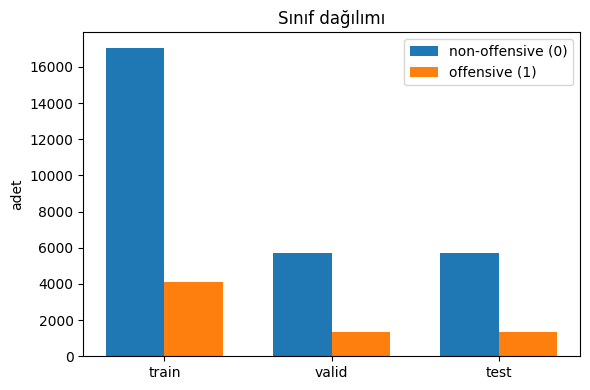

Kaydedildi: g1_class_balance.png


In [ ]:
# G1 — Sınıf dağılımı (bar grafiği)
import matplotlib.pyplot as plt
import numpy as np

splits = ["train","valid","test"]
pos = [int(np.sum(dtrain["y"])), int(np.sum(dvalid["y"])), int(np.sum(dtest["y"]))]
neg = [len(dtrain)-pos[0], len(dvalid)-pos[1], len(dtest)-pos[2]]

x = np.arange(len(splits))
w = 0.35

plt.figure(figsize=(6,4))
plt.bar(x - w/2, neg, width=w, label="non-offensive (0)")
plt.bar(x + w/2, pos, width=w, label="offensive (1)")
plt.xticks(x, splits)
plt.ylabel("adet")
plt.title("Sınıf dağılımı")
plt.legend()
plt.tight_layout()
plt.savefig("g1_class_balance.png", dpi=150)
plt.show()
print("Kaydedildi: g1_class_balance.png")


### **PR Eğrisi (Validation) + F1-max eşiği işaretli**

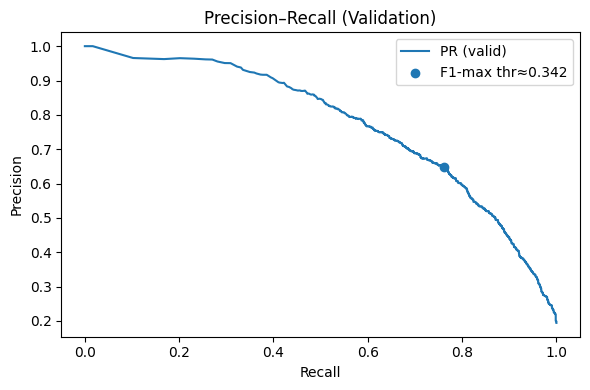

Kaydedildi: g2_pr_curve_valid.png


In [ ]:
# G2 — PR eğrisi (valid)
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_curve
import json

with open("artifacts/berturk/threshold.json","r",encoding="utf-8") as f:
    thr_bert = float(json.load(f)["threshold"])
try:
    probs_va
except NameError:
    # 7 veya 7.2 çalışmadıysa, son checkpoint/model ile valid olasılıkları üret
    import torch
    from transformers import AutoTokenizer, AutoModelForSequenceClassification
    tok  = AutoTokenizer.from_pretrained("artifacts/berturk/tokenizer")
    mdl  = AutoModelForSequenceClassification.from_pretrained("artifacts/berturk/model")
    device = "cuda" if torch.cuda.is_available() else "cpu"; mdl.to(device); mdl.eval()
    def _batched(texts, bs=64, max_len=160):
        out=[]
        for i in range(0,len(texts),bs):
            enc = tok(texts[i:i+bs], truncation=True, padding="max_length", max_length=max_len, return_tensors="pt")
            enc = {k:v.to(device) for k,v in enc.items()}
            with torch.no_grad(): logits = mdl(**enc).logits
            out.append(torch.softmax(logits,dim=1)[:,1].cpu().numpy())
        import numpy as np
        return np.concatenate(out)
    probs_va = _batched(dvalid["text"].tolist())

yv = dvalid["y"].values
prec, rec, thr = precision_recall_curve(yv, probs_va)
# thresholds ile hizalı metrikler
P, R, T = prec[:-1], rec[:-1], thr
F1 = 2*P*R/(P+R+1e-9)

plt.figure(figsize=(6,4))
plt.plot(rec, prec, label="PR (valid)")
# F1-max eşiğini işaretle
import numpy as np
# thr_bert'e en yakın threshold noktasını bul
i_near = int(np.argmin(np.abs(T - thr_bert)))
plt.scatter(R[i_near], P[i_near], marker="o", label=f"F1-max thr≈{thr_bert:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall (Validation)")
plt.legend()
plt.tight_layout()
plt.savefig("g2_pr_curve_valid.png", dpi=150)
plt.show()
print("Kaydedildi: g2_pr_curve_valid.png")


### **Karışıklık Matrisi (Test) @ F1-max eşiği**

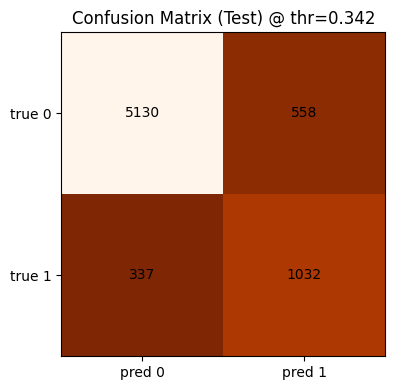

Kaydedildi: g4_cm_test_f1max.png


In [ ]:
# G4 — Confusion matrix (test)
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

try:
    probs_te
except NameError:
    # Test olasılıklarını üret
    import torch
    from transformers import AutoTokenizer, AutoModelForSequenceClassification
    tok  = AutoTokenizer.from_pretrained("artifacts/berturk/tokenizer")
    mdl  = AutoModelForSequenceClassification.from_pretrained("artifacts/berturk/model")
    device = "cuda" if torch.cuda.is_available() else "cpu"; mdl.to(device); mdl.eval()
    def _batched(texts, bs=64, max_len=160):
        out=[]
        for i in range(0,len(texts),bs):
            enc = tok(texts[i:i+bs], truncation=True, padding="max_length", max_length=max_len, return_tensors="pt")
            enc = {k:v.to(device) for k,v in enc.items()}
            with torch.no_grad(): logits = mdl(**enc).logits
            out.append(torch.softmax(logits,dim=1)[:,1].cpu().numpy())
        import numpy as np
        return np.concatenate(out)
    probs_te = _batched(dtest["text"].tolist())

yt = dtest["y"].values
yhat = (probs_te >= thr_bert).astype(int)
cm = confusion_matrix(yt, yhat, labels=[0,1])

plt.figure(figsize=(4.5,4))
plt.imshow(cm, cmap="Oranges_r")
for (i, j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha="center", va="center")
plt.xticks([0,1], ["pred 0","pred 1"])
plt.yticks([0,1], ["true 0","true 1"])
plt.title(f"Confusion Matrix (Test) @ thr={thr_bert:.3f}")
plt.tight_layout()
plt.savefig("g4_cm_test_f1max.png", dpi=150)
plt.show()
print("Kaydedildi: g4_cm_test_f1max.png")


### **Skor histogramları (Validation): pozitif vs negatif**

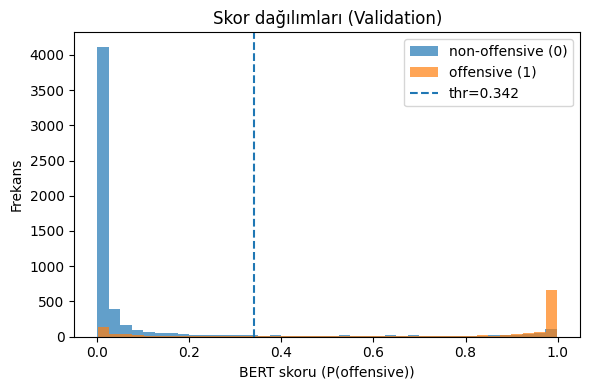

Kaydedildi: g5_score_hist_valid.png


In [ ]:
# G5 — Skor histogramı (valid)
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(6,4))
plt.hist(probs_va[yv==0], bins=40, alpha=0.7, label="non-offensive (0)")
plt.hist(probs_va[yv==1], bins=40, alpha=0.7, label="offensive (1)")
plt.axvline(thr_bert, linestyle="--", label=f"thr={thr_bert:.3f}")
plt.xlabel("BERT skoru (P(offensive))")
plt.ylabel("Frekans")
plt.title("Skor dağılımları (Validation)")
plt.legend()
plt.tight_layout()
plt.savefig("g5_score_hist_valid.png", dpi=150)
plt.show()
print("Kaydedildi: g5_score_hist_valid.png")
